<h1 align="center">Colocalization and Distance Measurements of Objects in Fluorescence Microscopy</h1>

**Summary:**

1. SimpleITK provides a large number of filters that enable segmentation and quantification of the segmented objects characteristics and spatial relationships between the objects.

This notebook will illustrate the construction of a SimpleITK based analysis workflow in which we quantify the colocalization of two markers (FITC and Cy3) and the distance between the protein blobs these define to the nucleus blob(s) defined by a third marker (DAPI). 

The image we work with was obtained by 3D Structured Illumination Microscopy (3D-SIM) and is provided courtesy of the Etienne Leygue lab at CancerCare Manitoba and The Genomic Centre for Cancer Research and Diagnosis.

In [1]:
import SimpleITK as sitk
import numpy as np
import pandas as pd


%matplotlib notebook
import gui

%run update_path_to_download_script
from downloaddata import fetch_data as fdata

from IPython.core.display import display, HTML

# Always write output to a separate directory, we don't want to pollute the source directory. 
import os
OUTPUT_DIR = 'Output'

# Load data
Load the 3D multi channel structured illumination microscopy image, split it into the separate channels and display them.

Fetching microscopy_colocalization.nrrd
Downloaded 121566654 of 121566654 bytes (100.00%)


<IPython.core.display.Javascript object>


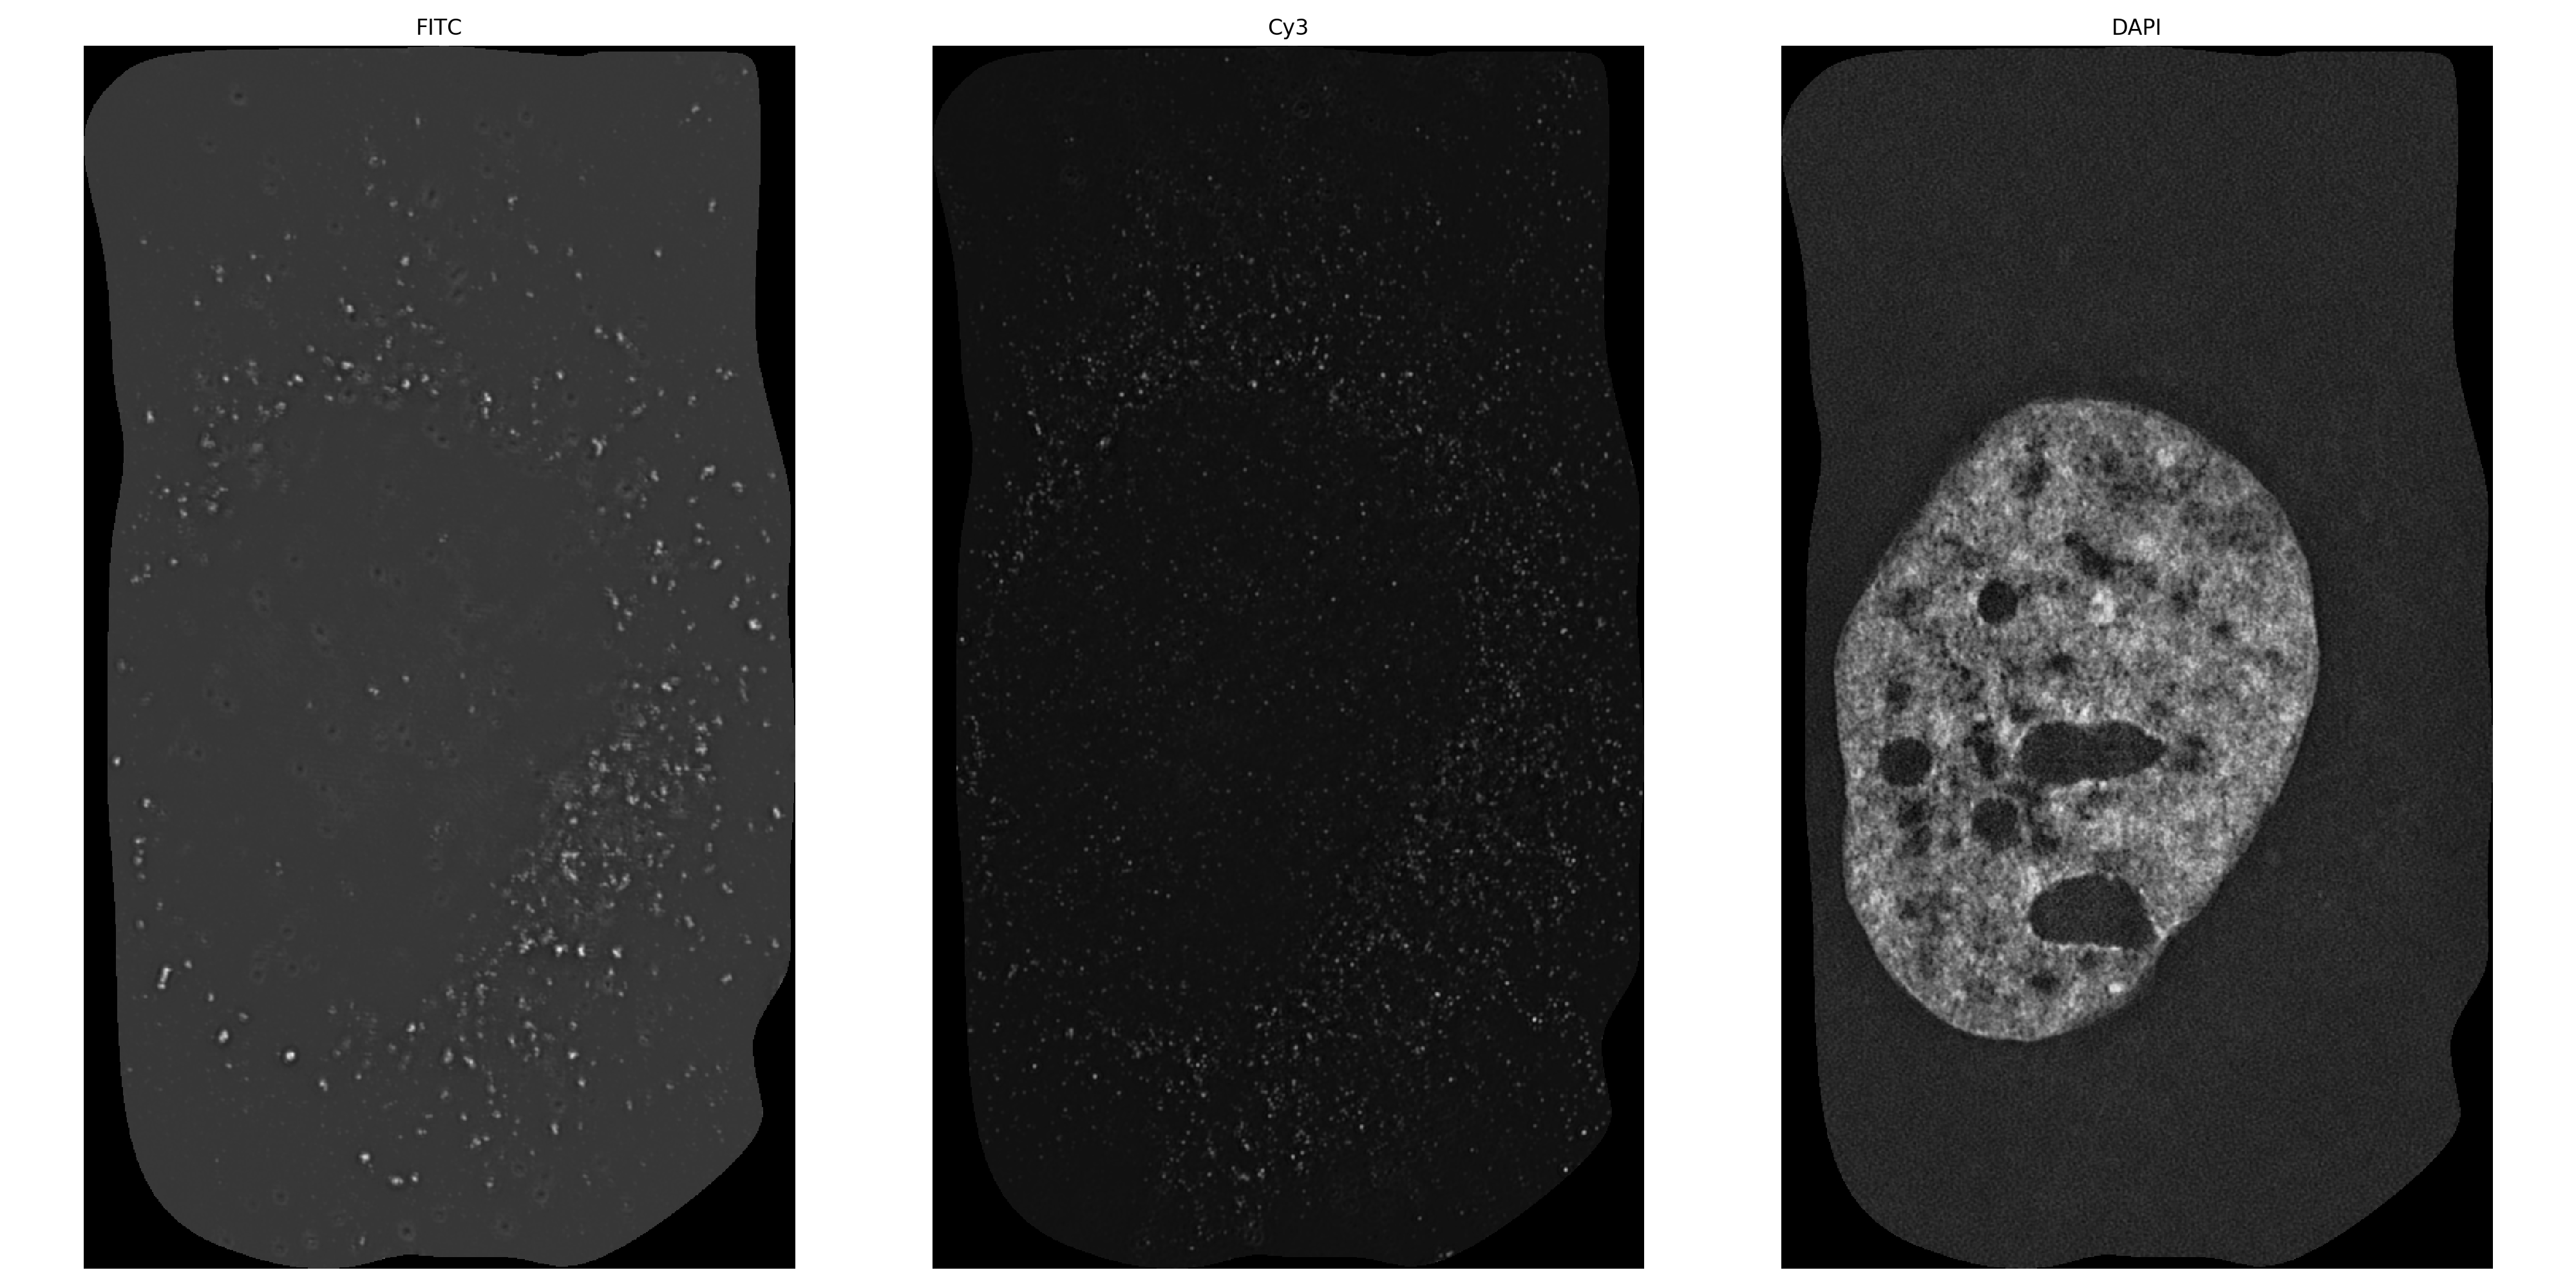

In [2]:
sim_image = sitk.ReadImage(fdata('microscopy_colocalization.nrrd'))

#Our original image was saved using mm as the unit size, but in microscopy the more common unit is um.
#We modify the size so that it is in um. If your image is in um you won't have to perform this modification.
sim_image.SetSpacing([spc*1000 for spc in sim_image.GetSpacing()])
sim_image.SetOrigin([org*1000 for org in sim_image.GetOrigin()])

# The channel name appears in the image's meta-data dictionary with key: channel_i_name
channel_titles = [sim_image.GetMetaData('channel_{0}_name'.format(i)) for i in range(sim_image.GetNumberOfComponentsPerPixel())]
channels = [sitk.VectorIndexSelectionCast(sim_image,i) 
            for i in range(sim_image.GetNumberOfComponentsPerPixel())]
fitc_image = channels[channel_titles.index('FITC')]
cy3_image = channels[channel_titles.index('Cy3')]
dapi_image = channels[channel_titles.index('DAPI')]

gui.MultiImageDisplay(image_list=channels, title_list=channel_titles, shared_slider=True, 
                      intensity_slider_range_percentile=[0,100],
                      figure_size=(20,10));

## Segmenting Channels

Based on the visualization above we perform manual segmentation, visually estimating thresholds for the three channels, isolating our objects of interest.

As we know that the image contains a single nucleus we take the largest connected component in the thresholded DAPI channel as the nucleus. When there are multiple nuclei more sophisticated methods may be needed.

<IPython.core.display.Javascript object>


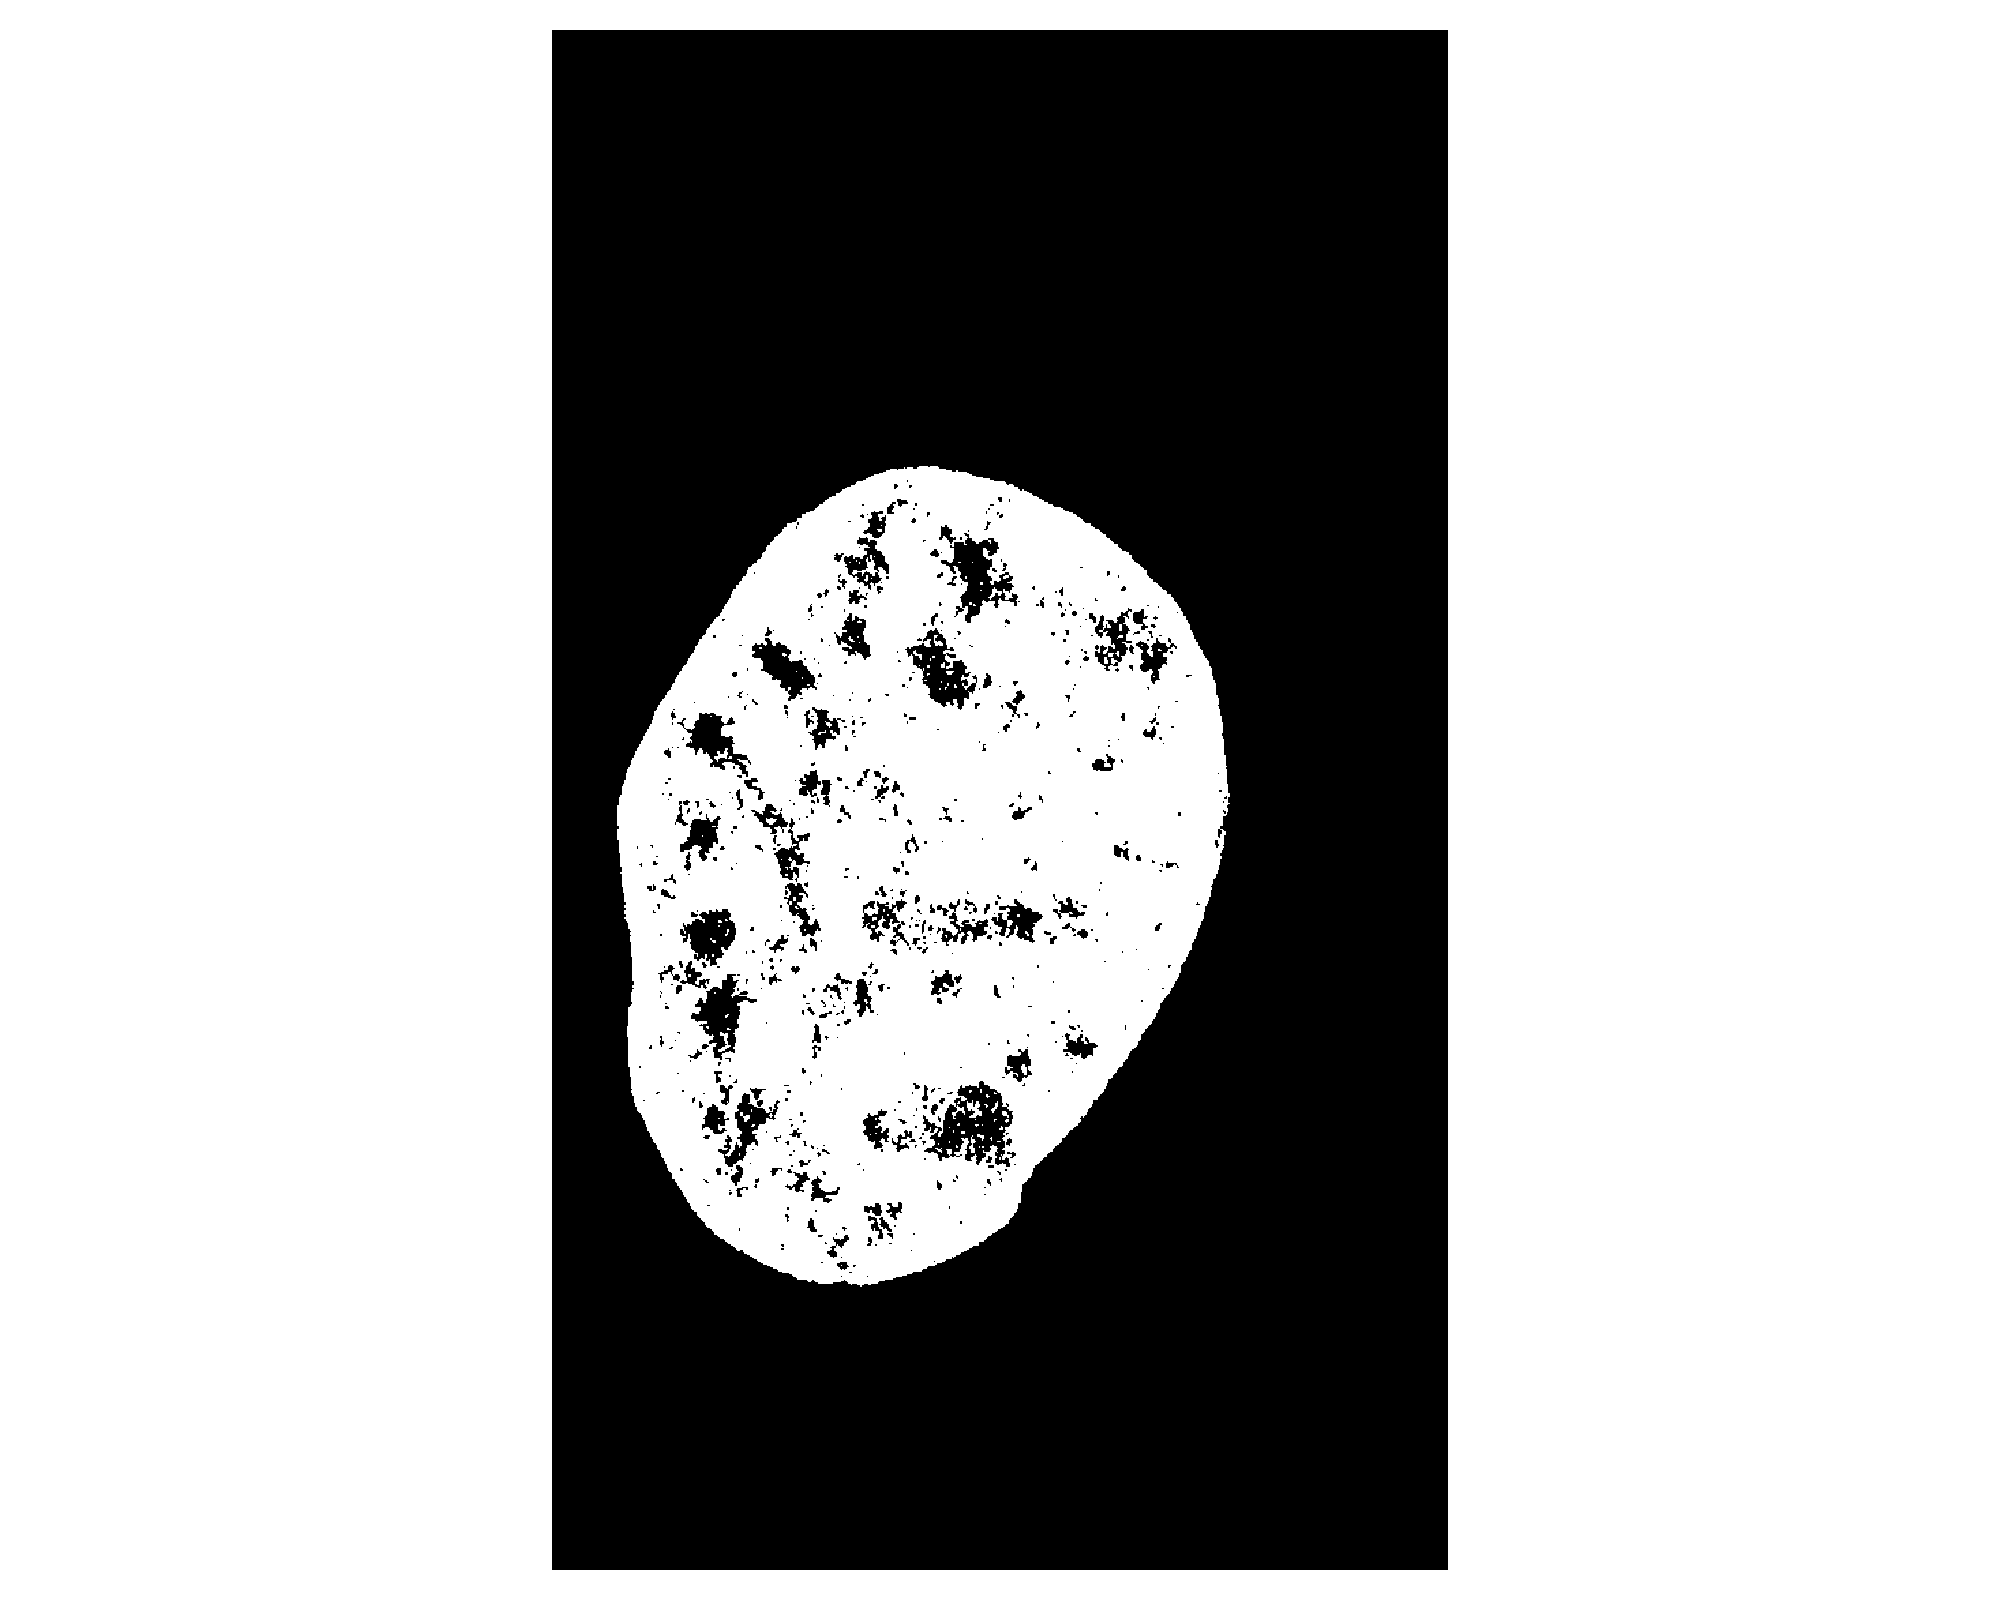

In [3]:
fitc_threshold = 10000
cy3_threshold = 10000
dapi_threshold = 12000

# Segment the nucleus marker image and then label each connected component. 
dapi_binary_segmentation = dapi_image > dapi_threshold

dapi_labeled_segmentation = sitk.ConnectedComponent(dapi_binary_segmentation)
# Our simple thresholding creates many small connected components. We have a 
# single nucleus so we relabel and take the largest connected component.
# Minimal object size is given as number of voxels.
dapi_labeled_segmentation = sitk.RelabelComponent(dapi_labeled_segmentation, minimumObjectSize=1000, sortByObjectSize=True)
dapi_binary_segmentation = dapi_labeled_segmentation == 1

dapi_stats_filter = sitk.LabelShapeStatisticsImageFilter()
dapi_stats_filter.Execute(dapi_labeled_segmentation)

# Segment the protein marker images and label each connected component.
markers_binary_segmentations = [fitc_image > fitc_threshold,
                                cy3_image > cy3_threshold]
markers_labeled_segmentations = [sitk.ConnectedComponent(marker_binary_segmentation) \
                                 for marker_binary_segmentation in markers_binary_segmentations]
gui.MultiImageDisplay([dapi_binary_segmentation]);

## Colocalization

The locations of the specific protein we are interested in correspond to locations where there is overlap between the markers. In our case FITC and Cy3.

In the next cell we compute various size characteristics of the colocalized markers (voxels, volume, percentage of overlap from original markers).

In [4]:
from numba import njit

@njit
def first_index(arr, val):
    '''
    Find the index of the first appearance of val in arr. The loop is extremely slow in Python, but we use
    the numba just-in-time compiler to optimize it (@njit decorator). Another option is to use np.where 
    which returns all indexes but that is significantly (six times) slower than using the numba optimized function.
    '''    
    for index, value in np.ndenumerate(arr):
        if val == value:
             return index

markers_names = ['FITC', 'Cy3']

# Compute the label statistics for all protein markers. 
def apply_label_shape_filter(label_image):
    filt=sitk.LabelShapeStatisticsImageFilter()
    filt.Execute(label_image)
    return filt
markers_stats_filters = [apply_label_shape_filter(labeled_seg) for labeled_seg in markers_labeled_segmentations]

# Compute the colocalization image and label each connected component.
colocalization_binary_segmentation = markers_binary_segmentations[0]
for binary_segmentation in markers_binary_segmentations[1:]:
    colocalization_binary_segmentation = colocalization_binary_segmentation * binary_segmentation
colocolization_labeled_segmentation = sitk.ConnectedComponent(colocalization_binary_segmentation)    

# Compute the label statistics for the colocalized protein markers.
colocolization_stats_filter = sitk.LabelShapeStatisticsImageFilter()
colocolization_stats_filter.Execute(colocolization_labeled_segmentation)

# Create a dictionary that maps between the colocalization labels and the individual labels from
# each marker.
colocalization_labels_2_original_labels = {}
colocolization_labeled_segmentation_arr_view = sitk.GetArrayViewFromImage(colocolization_labeled_segmentation)
for label in colocolization_stats_filter.GetLabels():
    # The index into the numpy array needs to be flipped as the order in numpy is zyx and in SimpleITK xyz
    index = first_index(colocolization_labeled_segmentation_arr_view, label)[::-1]
    colocalization_labels_2_original_labels[label] = [labeled_seg[index] for labeled_seg in markers_labeled_segmentations]
    
# Compute statistics for the colocalizations. Work with a list of lists and then 
# combine into a dataframe, faster than appending to the dataframe one by one.
column_titles = ['colocalization size']*2 + [item for sublist in [[marker]*4 for marker in markers_names] for item in sublist]
all_colocalizations_data = []
for item in colocalization_labels_2_original_labels.items():
    coloc_size = colocolization_stats_filter.GetPhysicalSize(item[0])
    marker_labels_list = item[1]
    current_colocalization = [coloc_size, colocolization_stats_filter.GetNumberOfPixels(item[0])] + \
                             [item for sublist in [[label,filt.GetPhysicalSize(label),filt.GetNumberOfPixels(label),coloc_size/filt.GetPhysicalSize(label)] 
                                                   for label,filt in zip(marker_labels_list, markers_stats_filters)] for item in sublist]
    all_colocalizations_data.append(current_colocalization)
    
colocalization_information_df = \
    pd.DataFrame(all_colocalizations_data, columns=column_titles)
marker_columns = ['label', 'size [um^3]', 'size[voxels]', 'colocalization percentage']
colocalization_information_df.columns = pd.MultiIndex.from_tuples(zip(colocalization_information_df.columns, 
                                          ['um^3', 'voxels'] + [item for sublist in [marker_columns for item in markers_names] for item in sublist]))
# Save the colocalization results
colocalization_information_df.to_csv(os.path.join(OUTPUT_DIR,'colocalization.csv'), index=False)

# Display the first N rows as HTML
head_length=20
display(HTML(colocalization_information_df.head(head_length).to_html(index=False)))

## Distance of colocalizations from nuclei

We now compute the distances between marker colocalization blobs to nuclei blobs, both edge (boundary) to edge distance and center to center distance. The centroid of a blob is defined as the location in physical space of the mean of the blob voxel locations. Consequentially, if the blob is not convex the centroid may lie outside the blob.

Edge to edge distances are computed using a distance map, this treats all nuclei as a single object.

In [ ]:
# Compute the edge to edge distances using the absolute distance map from the nuclei segmentation.
distance_map_from_all_nuclei = sitk.Abs(sitk.SignedMaurerDistanceMap(dapi_binary_segmentation, squaredDistance=False, useImageSpacing=True))

distance_stats_filter = sitk.LabelIntensityStatisticsImageFilter()
distance_stats_filter.Execute(colocolization_labeled_segmentation, distance_map_from_all_nuclei)

labels_edge_distances = []
for label in distance_stats_filter.GetLabels():
    # Using minimum for each label gives us edge to edge distance
    labels_edge_distances.append(colocalization_labels_2_original_labels[label] + [distance_stats_filter.GetMinimum(label)]) 
    
ee_distances_df = pd.DataFrame(labels_edge_distances, columns = markers_names + ['edge edge distance to DAPI [um]'])
ee_distances_df.to_csv(os.path.join(OUTPUT_DIR,'colocalization_edge_edge_distances.csv'), index=False)

# Display the first N rows as HTML, sorted according to distance from nuclei
head_length=20
display(HTML(ee_distances_df.sort_values(by='edge edge distance to DAPI [um]').head(head_length).to_html(index=False)))

## Trust but Verify

Visually check that the colocalizations with zero distance indeed agree with our computations using the distance map.

Scroll through the image stack and then zoom in on a region with "light" pixels using the zoom tool (box /rubber band menu item). Zoom in in both images and hover with the mouse over the light pixels. On the bottom right you will see the pixel location and value. The pixel value is the label of that pixel. The combination of labels should match the table that appears above this cell.

In [ ]:
zero_distance_mask = sitk.Cast(colocalization_binary_segmentation*dapi_binary_segmentation, markers_labeled_segmentations[0].GetPixelIDValue())

FITC_labels_zero_distance = zero_distance_mask*markers_labeled_segmentations[0]
Cy3_labels_zero_distance = zero_distance_mask*markers_labeled_segmentations[1]

gui.MultiImageDisplay(image_list=[FITC_labels_zero_distance, Cy3_labels_zero_distance], 
                      title_list=['FITC labels', 'Cy3 labels'], shared_slider=True, 
                      intensity_slider_range_percentile=[0,100],
                      figure_size=(10,5));

## Distance of colocalizations from nuclei centers

Determining how close proteins (or genes if that is your interest) is to the center of the nucleus. Note that this distance is not symmetric, the distance between a protein to the closest nucleus is not the same as the distance between that nucleus and the closest protein.

In [ ]:
colocalization_labels, colocalization_centroids = zip(*[(coloc_label, colocolization_stats_filter.GetCentroid(coloc_label)) for coloc_label in colocolization_stats_filter.GetLabels()])
colocalization_centroids = np.array(colocalization_centroids)

nuclei_labels, nuclei_centroids = zip(*[(nucleus, dapi_stats_filter.GetCentroid(nucleus)) for nucleus in dapi_stats_filter.GetLabels()])
nuclei_centroids = np.array(nuclei_centroids)

# Compute minimal distances and matching labels
all_distances = -2 * np.dot(colocalization_centroids, nuclei_centroids.T)
all_distances += np.sum(colocalization_centroids**2, axis=1)[:, np.newaxis]
all_distances += np.sum(nuclei_centroids**2, axis=1)
all_distances = np.sqrt(all_distances)

min_indexes = np.argmin(all_distances, axis=1)

results = list(zip(colocalization_labels, tuple(np.array(nuclei_labels)[min_indexes]), all_distances[np.arange(len(min_indexes)), min_indexes]))
# Replace the colocalization labels with the original channel labels
results = [colocalization_labels_2_original_labels[coloc_label] + list((nucleus_label, distance)) for coloc_label, nucleus_label, distance in results]

cc_distances_df = pd.DataFrame(results, columns = markers_names + ['DAPI', 'centroid centroid distance [um]'])
cc_distances_df.to_csv(os.path.join(OUTPUT_DIR,'colocalization_centroid_centroid_distances.csv'), index=False)

# Display the first N rows as HTML
head_length=20
display(HTML(cc_distances_df.head(head_length).to_html(index=False)))